# EDA PART


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

csv_path = Path.home() / "Documents" / "data1030-fall2025" / "data" / "final_pre.csv" 
df = pd.read_csv(csv_path)
df

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


In [2]:
print(df.shape)        
print(df.columns)

(43824, 13)
Index(['No', 'year', 'month', 'day', 'hour', 'pm2.5', 'DEWP', 'TEMP', 'PRES',
       'cbwd', 'Iws', 'Is', 'Ir'],
      dtype='object')


Time series (line) — PM2.5 over time (daily or weekly aggregate)

Text(0, 0.5, 'pm2.5')

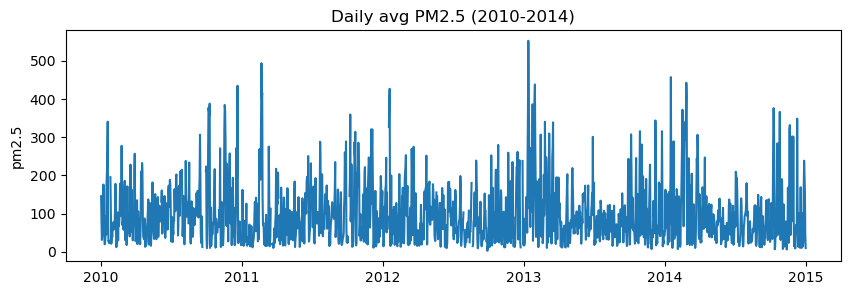

In [3]:
df['datetime'] = pd.to_datetime(df[['year','month','day','hour']])
ts = df.set_index('datetime')['pm2.5'].resample('D').mean()
plt.figure(figsize=(10,3))
plt.plot(ts)
plt.title('Daily avg PM2.5 (2010-2014)')
plt.ylabel('pm2.5')

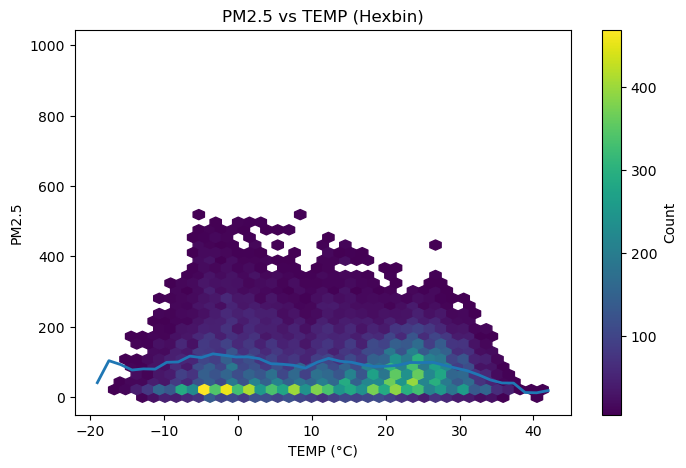

In [4]:
import numpy as np


plt.figure(figsize=(8,5))
clean = df[['TEMP','pm2.5']].dropna()
hb = plt.hexbin(clean['TEMP'], clean['pm2.5'], gridsize=40, mincnt=5)
plt.colorbar(hb, label='Count')
plt.title('PM2.5 vs TEMP (Hexbin)')
plt.xlabel('TEMP (°C)'); plt.ylabel('PM2.5')
bins = np.linspace(clean['TEMP'].min(), clean['TEMP'].max(), 40)
inds = np.digitize(clean['TEMP'], bins)
means = [clean.loc[inds==i, 'pm2.5'].mean() for i in range(1, len(bins)+1)]
plt.plot(bins, means, linewidth=2)

## Rain or Snow affect PM2.5

/var/folders/8m/sdygf9451838fny1vdhdj0rh0000gn/T/ipykernel_3498/1646271066.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


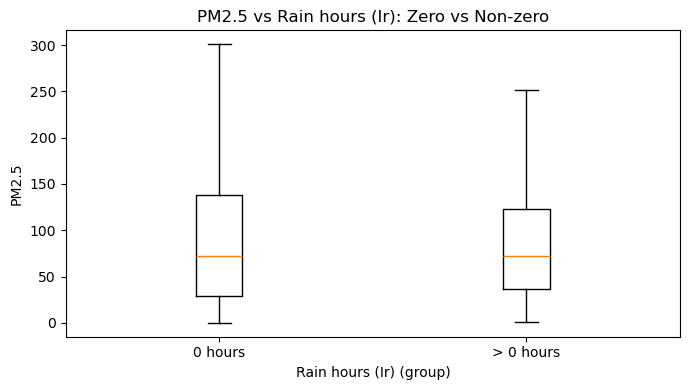

/var/folders/8m/sdygf9451838fny1vdhdj0rh0000gn/T/ipykernel_3498/1646271066.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


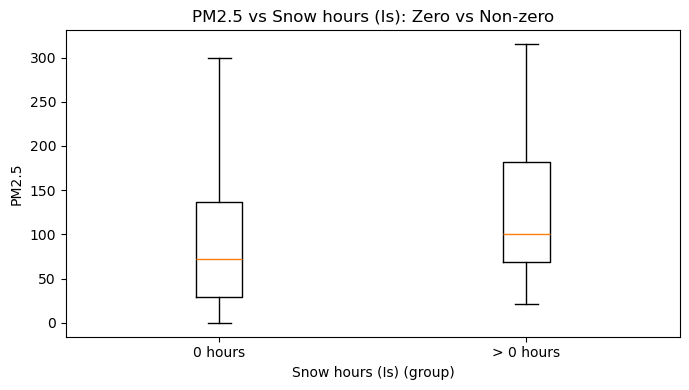

/var/folders/8m/sdygf9451838fny1vdhdj0rh0000gn/T/ipykernel_3498/1646271066.py:45: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels, showfliers=False)


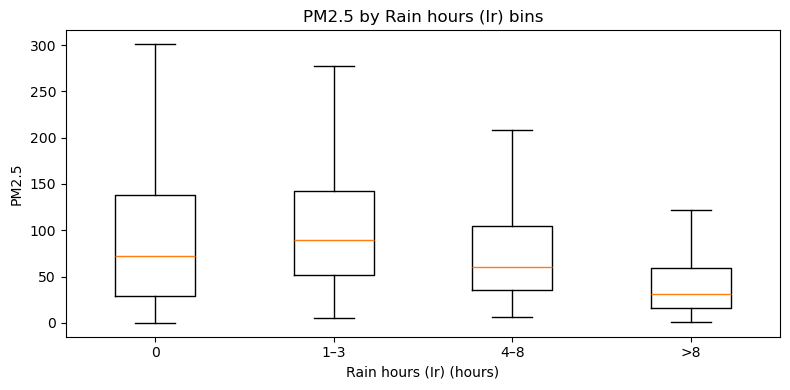

/var/folders/8m/sdygf9451838fny1vdhdj0rh0000gn/T/ipykernel_3498/1646271066.py:45: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels, showfliers=False)


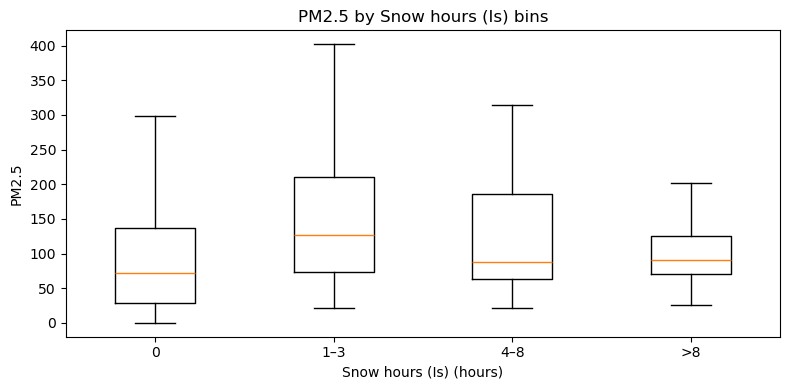

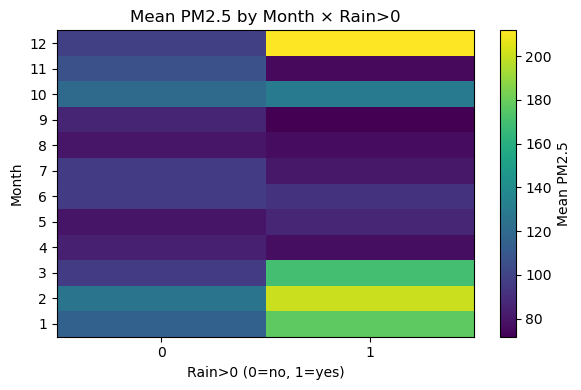

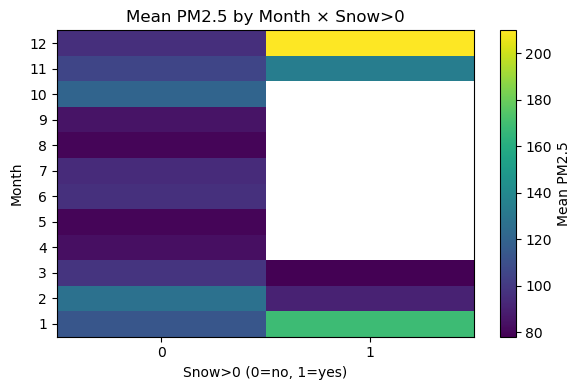

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Prep
df = df.copy()
df['month'] = df['datetime'].dt.month

# -------------------------
# 1) Zero vs non-zero effect
# -------------------------
def zero_nonzero_boxplot(feature, title_suffix):
    z = df[[feature, 'pm2.5']].dropna()
    z['has_precip'] = (z[feature] > 0).astype(int)

    data = [
        z.loc[z['has_precip'] == 0, 'pm2.5'].values,
        z.loc[z['has_precip'] == 1, 'pm2.5'].values
    ]
    labels = ['0 hours', '> 0 hours']

    plt.figure(figsize=(7,4))
    plt.boxplot(data, labels=labels, showfliers=False)
    plt.title(f'PM2.5 vs {title_suffix}: Zero vs Non-zero')
    plt.xlabel(f'{title_suffix} (group)')
    plt.ylabel('PM2.5')
    plt.tight_layout()
    plt.show()

zero_nonzero_boxplot('Ir', 'Rain hours (Ir)')
zero_nonzero_boxplot('Is', 'Snow hours (Is)')

# ---------------------------------------------
# 2) Dose–response by bins (0, 1–3, 4–8, >8 h)
# ---------------------------------------------
def dose_response_boxplot(feature, title_suffix):
    x = df[[feature, 'pm2.5']].dropna().copy()
    bins = [-0.5, 0.5, 3.5, 8.5, np.inf]  # 0, 1-3, 4-8, >8
    labels = ['0', '1–3', '4–8', '>8']
    x['bin'] = pd.cut(x[feature], bins=bins, labels=labels)

    groups = [x.loc[x['bin']==lab, 'pm2.5'].values for lab in labels]

    plt.figure(figsize=(8,4))
    plt.boxplot(groups, labels=labels, showfliers=False)
    plt.title(f'PM2.5 by {title_suffix} bins')
    plt.xlabel(f'{title_suffix} (hours)')
    plt.ylabel('PM2.5')
    plt.tight_layout()
    plt.show()

dose_response_boxplot('Ir', 'Rain hours (Ir)')
dose_response_boxplot('Is', 'Snow hours (Is)')

# ------------------------------------------------------
# 3) Seasonal context: month × (precip>0) mean PM2.5 map
# ------------------------------------------------------
def month_precip_heatmap(feature, title_suffix):
    temp = df[['month', feature, 'pm2.5']].dropna().copy()
    temp['has_precip'] = (temp[feature] > 0).astype(int)

    # pivot: rows = month, cols = has_precip (0/1), values = mean PM2.5
    pivot = temp.pivot_table(index='month', columns='has_precip', values='pm2.5', aggfunc='mean')
    pivot = pivot.reindex(index=range(1,13))  # months 1..12

    arr = pivot.values  # shape (12, 2)

    plt.figure(figsize=(6,4))
    plt.imshow(arr, aspect='auto', origin='lower')
    plt.colorbar(label='Mean PM2.5')
    plt.title(f'Mean PM2.5 by Month × {title_suffix}>0')
    plt.xlabel(f'{title_suffix}>0 (0=no, 1=yes)')
    plt.ylabel('Month')
    plt.xticks([0,1],[0,1])
    plt.yticks(range(0,12), range(1,13))
    plt.tight_layout()
    plt.show()

month_precip_heatmap('Ir', 'Rain')
month_precip_heatmap('Is', 'Snow')


## Wind Direction 

/var/folders/8m/sdygf9451838fny1vdhdj0rh0000gn/T/ipykernel_3498/993196509.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=cats, showfliers=False)


Text(0, 0.5, 'PM2.5')

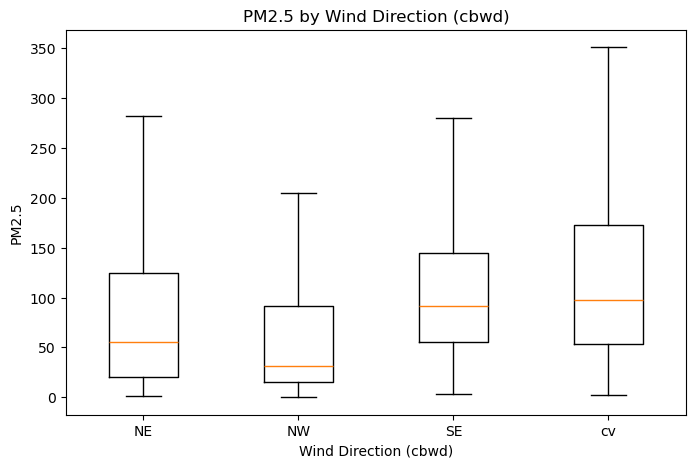

In [6]:
plt.figure(figsize=(8,5))
cats = sorted(df['cbwd'].dropna().unique())
data = [df.loc[df['cbwd']==cat, 'pm2.5'].dropna().values for cat in cats]
plt.boxplot(data, labels=cats, showfliers=False)
plt.title('PM2.5 by Wind Direction (cbwd)')
plt.xlabel('Wind Direction (cbwd)')
plt.ylabel('PM2.5')

## Pressure

/var/folders/8m/sdygf9451838fny1vdhdj0rh0000gn/T/ipykernel_3498/3349593315.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels, showfliers=False)


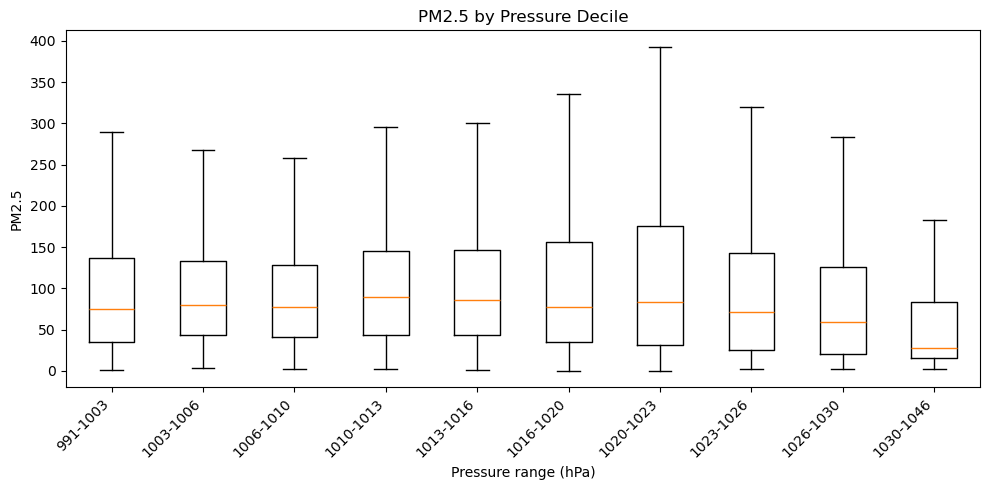

In [7]:
use = df[['PRES','pm2.5']].dropna().rename(columns={'pm2.5':'pm25'})
P, Y = use['PRES'].to_numpy(), use['pm25'].to_numpy()
deciles = np.quantile(P, np.linspace(0,1,11))
labels  = [f'{int(deciles[i])}-{int(deciles[i+1])}' for i in range(10)]
groups  = []
for i in range(10):
    lo, hi = deciles[i], deciles[i+1]
    mask = (P >= lo) & (P < hi) if i < 9 else (P >= lo) & (P <= hi)
    groups.append(Y[mask])

plt.figure(figsize=(10,5))
plt.boxplot(groups, labels=labels, showfliers=False)
plt.title('PM2.5 by Pressure Decile')
plt.xlabel('Pressure range (hPa)'); plt.ylabel('PM2.5')
plt.xticks(rotation=45, ha='right'); plt.tight_layout()


Heatmap / correlation matrix for numeric features

([<matplotlib.axis.YTick at 0x136ca2c90>,
 [Text(0, 0, 'pm2.5'),
  Text(0, 1, 'DEWP'),
  Text(0, 2, 'TEMP'),
  Text(0, 3, 'PRES'),
  Text(0, 4, 'Iws'),
  Text(0, 5, 'Is'),
  Text(0, 6, 'Ir')])

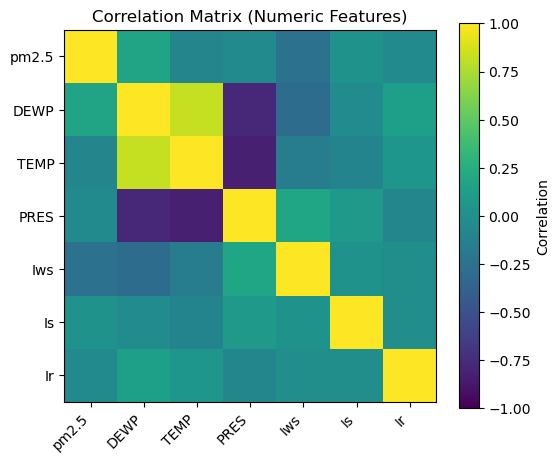

In [8]:
# 5) Correlation heatmap (numeric)
num_cols = ['pm2.5','DEWP','TEMP','PRES','Iws','Is','Ir']
corr = df[num_cols].dropna().corr()
plt.figure(figsize=(6,5)); im = plt.imshow(corr.values, origin='upper', vmin=-1, vmax=1)
plt.colorbar(im, label='Correlation'); plt.title('Correlation Matrix (Numeric Features)')
plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha='right'); plt.yticks(range(len(num_cols)), num_cols)


Boxplots by month/hour to show seasonality/diurnal patterns

## pandas plottig autocorrelation_plot  

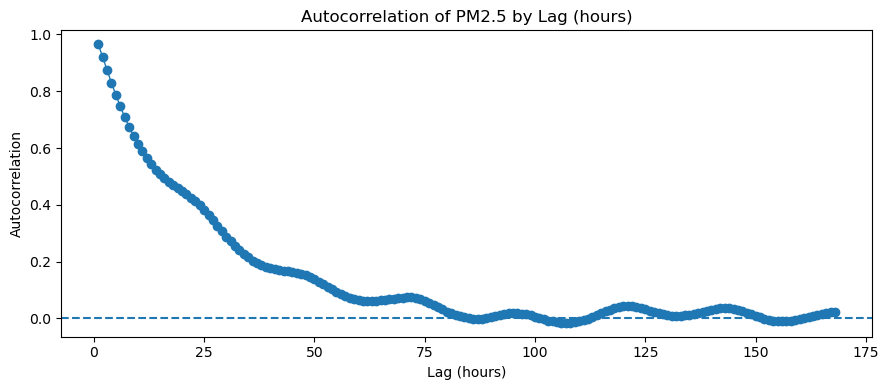

In [9]:
df = df.sort_values('datetime').reset_index(drop=True)
s = df.set_index('datetime')['pm2.5'].astype(float)  
s = df.set_index('datetime')['pm2.5'].astype(float)  
max_lag = 24*7
lags = np.arange(1, max_lag+1)
ac = np.array([s.autocorr(lag=i) for i in lags])

plt.figure(figsize=(9,4))
plt.plot(lags, ac, marker='o', linewidth=1)
plt.axhline(0, linestyle='--')
plt.title('Autocorrelation of PM2.5 by Lag (hours)')
plt.xlabel('Lag (hours)')
plt.ylabel('Autocorrelation')
plt.tight_layout()
# plt.savefig('/mnt/data/pm25_autocorr_line.png', dpi=200)
plt.show()




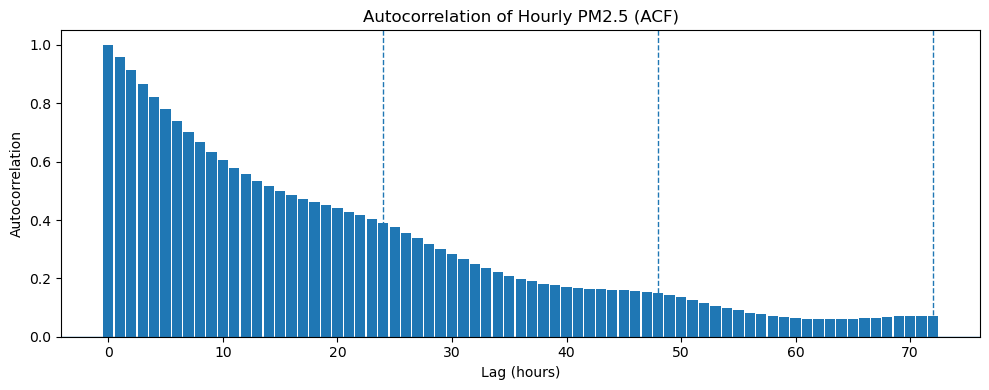

In [10]:

df = df.sort_values('datetime').reset_index(drop=True)

# Use the hourly target series
y = df['pm2.5'].astype(float)

# ============ 1) Autocorrelation Function (ACF) ============
def acf(series, nlags):
    """Normalized (biased) autocorrelation up to nlags (inclusive)."""
    x = np.asarray(series, dtype=float)
    x = x - np.nanmean(x)
    # Replace NaNs with 0 so correlations skip missing influence
    x = np.where(np.isnan(x), 0.0, x)
    denom = np.dot(x, x)
    acf_vals = [1.0]
    for k in range(1, nlags + 1):
        num = np.dot(x[:-k], x[k:])
        acf_vals.append(num / denom if denom != 0 else np.nan)
    return np.array(acf_vals)

nlags = 72  
acf_vals = acf(y, nlags)

plt.figure(figsize=(10, 4))
plt.bar(range(nlags + 1), acf_vals, width=0.9)
plt.title('Autocorrelation of Hourly PM2.5 (ACF)')
plt.xlabel('Lag (hours)')
plt.ylabel('Autocorrelation')
# Optional reference lines
plt.axhline(0, linewidth=1)
# Annotate daily-cycle lags
for k in (24, 48, 72):
    if k <= nlags:
        plt.axvline(k, linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()


# Splitting: time series

In [11]:
# --- build X, y (pick your features) ---
feat_cols = ['DEWP','TEMP','PRES','Iws','Is','Ir']  # add engineered cols if you have them
target    = 'pm2.5'

df_ = df.sort_values('datetime').dropna(subset=[target]).reset_index(drop=True)
X = df_[feat_cols].to_numpy()
y = df_[target].to_numpy()

# --- time-aware split in your style (no randomness, preserves order) ---
random_state = 137  # (kept for parity with your format; unused here)

n   = len(X)
ntr = int(0.6 * n)          # 60% train
nva = int(0.2 * n)          # 20% val
nts = n - ntr - nva         # 20% test

# first split to separate out the training set (oldest 60%)
X_train, y_train = X[:ntr], y[:ntr]
X_other, y_other = X[ntr:], y[ntr:]
print('training set:', X_train.shape, y_train.shape)  # 60% in train
print('other set   :', X_other.shape, y_other.shape)  # 40% in other

# second split to separate out the validation and test sets (next 20% vs last 20%)
X_val,   y_val   = X_other[:nva], y_other[:nva]      # validation = next 20%
X_test,  y_test  = X_other[nva:], y_other[nva:]      # test       = last 20%
print('validation set:', X_val.shape, y_val.shape)   # 20% in validation
print('test set:',       X_test.shape, y_test.shape) # 20% in test

# save split dates (handy for captions)
date_train_end = df_.loc[ntr-1, 'datetime']
date_val_end   = df_.loc[ntr+nva-1, 'datetime']
print("Train end:", date_train_end, "| Val end:", date_val_end, "| Test end:", df_.iloc[-1]['datetime'])


training set: (25054, 6) (25054,)
other set   : (16703, 6) (16703,)
validation set: (8351, 6) (8351,)
test set: (8352, 6) (8352,)
Train end: 2013-01-27 15:00:00 | Val end: 2014-01-14 01:00:00 | Test end: 2014-12-31 23:00:00


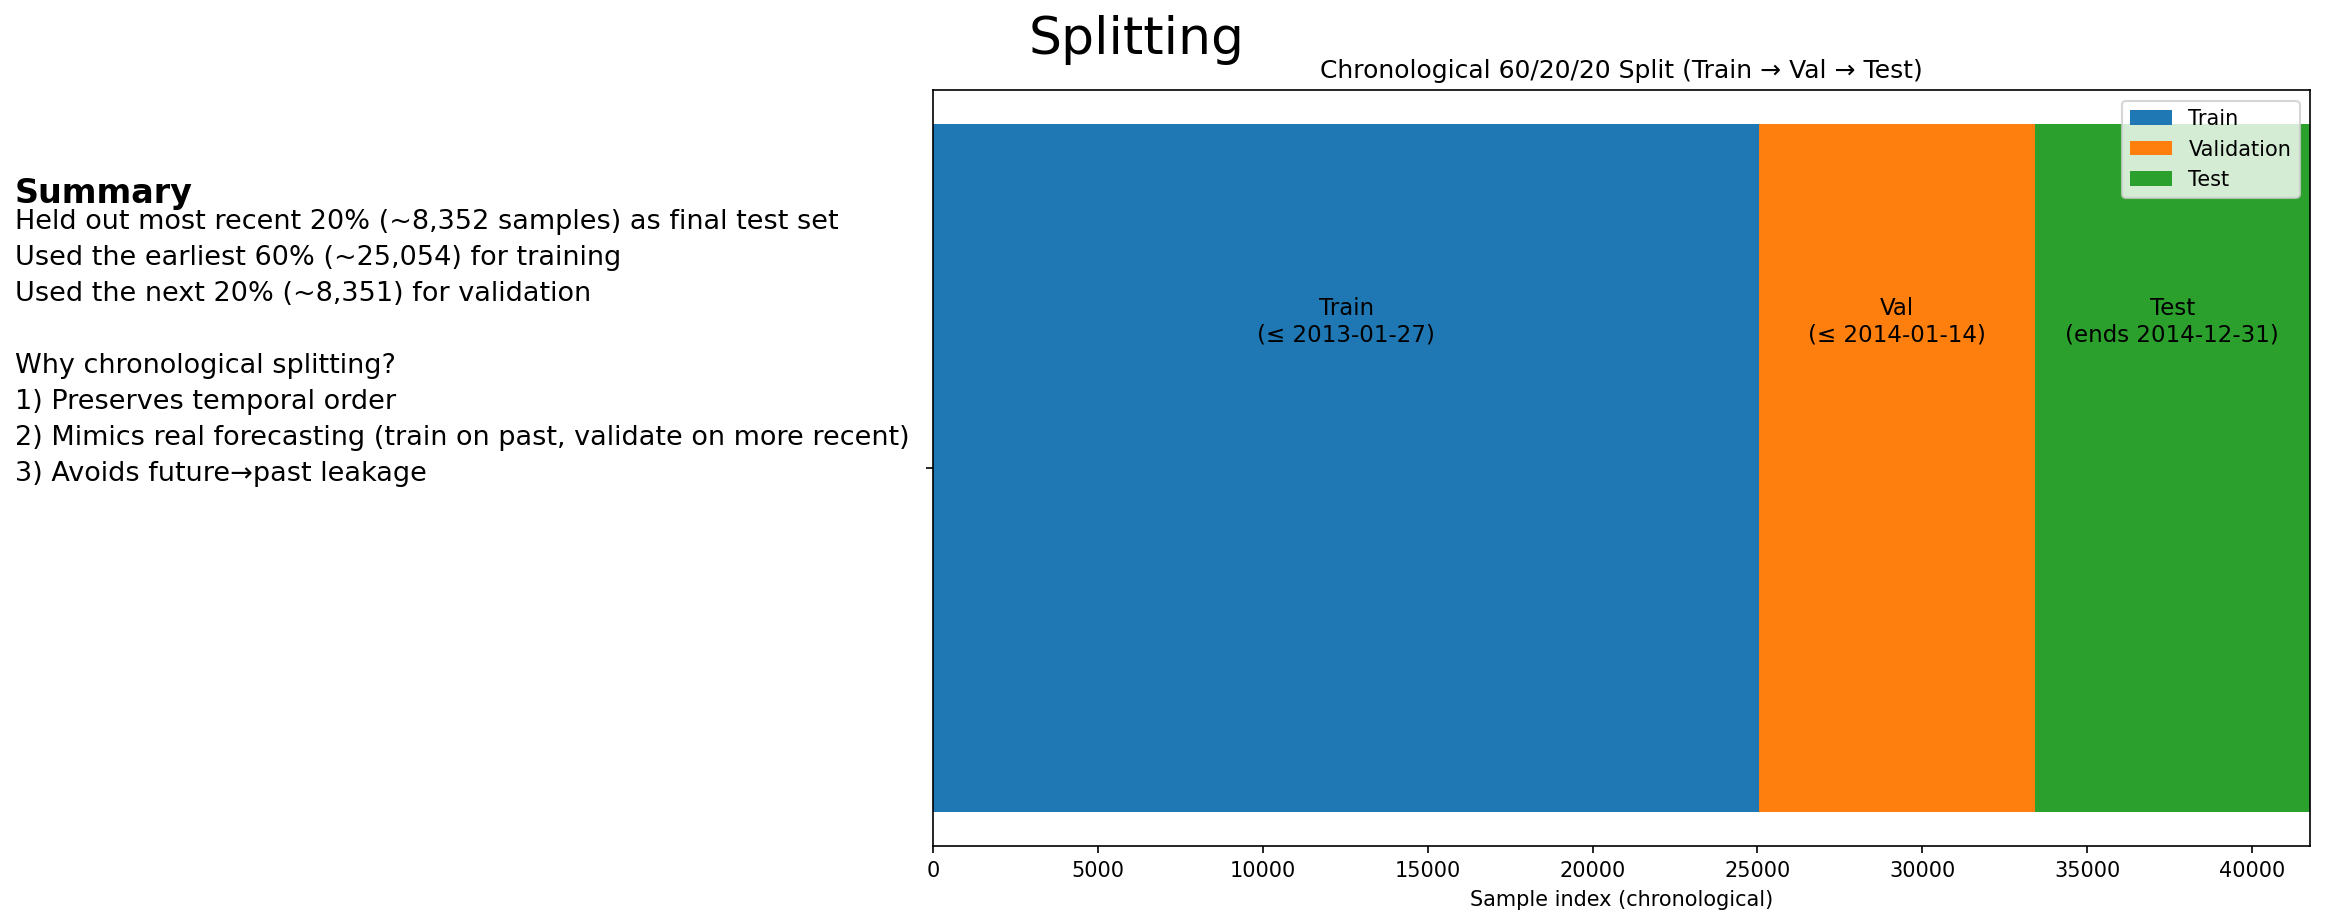

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 0) Ensure df has a datetime column and is sorted chronologically
# (If df already exists, you can skip the next two lines.)
# df = pd.read_csv('/path/to/PRSA_data_2010.1.1-2014.12.31.csv')
# df['datetime'] = pd.to_datetime(df[['year','month','day','hour']])

df_ = df.sort_values('datetime').dropna(subset=['pm2.5']).reset_index(drop=True)

# 1) 60/20/20 chronological split (NO shuffling)
feat_cols = ['DEWP','TEMP','PRES','Iws','Is','Ir']  
n   = len(df_)
ntr = int(0.60 * n)               # oldest 60% → Train
nva = int(0.20 * n)               # next   20% → Val
nts = n - ntr - nva               # most recent 20% → Test

date_train_end = df_.loc[ntr-1,       'datetime']
date_val_end   = df_.loc[ntr+nva-1,   'datetime']
date_test_end  = df_.iloc[-1]['datetime']

# 2) Build the slide
fig = plt.figure(figsize=(17, 7.2), dpi=150)
fig.suptitle('Splitting', fontsize=25, y=0.95)

# Right: horizontal bar diagram (single axes)
ax = fig.add_axes([0.42, 0.18, 0.54, 0.70])  # left, bottom, width, height
ax.barh(1, width=ntr,        left=0,       height=0.45, label='Train')
ax.barh(1, width=nva,        left=ntr,     height=0.45, label='Validation')
ax.barh(1, width=nts,        left=ntr+nva, height=0.45, label='Test')

ax.set_yticks([1]); ax.set_yticklabels([''])
ax.set_xlim(0, n)
ax.set_xlabel('Sample index (chronological)')
ax.set_title('Chronological 60/20/20 Split (Train → Val → Test)')
ax.legend(loc='upper right')

# Annotate with end dates
ax.text(ntr/2,            1.08, f"Train\n(≤ {date_train_end.date()})", ha='center', va='bottom', fontsize=11)
ax.text(ntr + nva/2,      1.08, f"Val\n(≤ {date_val_end.date()})",    ha='center', va='bottom', fontsize=11)
ax.text(ntr + nva + nts/2,1.08, f"Test\n(ends {date_test_end.date()})",ha='center', va='bottom', fontsize=11)

# Left: summary bullets
bullets = [
    f"Held out most recent 20% (~{nts:,} samples) as final test set",
    f"Used the earliest 60% (~{ntr:,}) for training",
    f"Used the next 20% (~{nva:,}) for validation",
    "",
    "Why chronological splitting?",
    "1) Preserves temporal order",
    "2) Mimics real forecasting (train on past, validate on more recent)",
    "3) Avoids future→past leakage",
]
fig.text(0.06, 0.80, "Summary", fontsize=16, fontweight='bold', ha='left', va='top')
fig.text(0.06, 0.77, "\n".join(bullets), fontsize=13, ha='left', va='top', linespacing=1.5)

plt.show()

time series  Kfold     timeseriessplit***

Features + preprocessing (context for the CV pipeline)


# Preprocessing

handle missing values + Standardscaler

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import numpy as np

target_col = 'pm2.5'

# Create time-based features and lag features FIRST, before splitting
df['hour'] = df['datetime'].dt.hour
df['hour_sin'] = np.sin(2*np.pi*df['hour']/24)
df['hour_cos'] = np.cos(2*np.pi*df['hour']/24)

df = df.sort_values('datetime').reset_index(drop=True)
df['pm2_1'] = df[target_col].shift(1)
df['pm2_24'] = df[target_col].shift(24)
df['pm2_24_mean'] = df[target_col].rolling(24).mean().shift(1)

# NOW split the data (after creating all features)
split_val = pd.to_datetime('2014-01-01')
split_test = pd.to_datetime('2014-07-01')

train = df[df['datetime'] < split_val]
val = df[(df['datetime'] >= split_val) & (df['datetime'] < split_test)]
test = df[df['datetime'] >= split_test]

# Analyze missingness
missing_by_col = df.isna().mean().sort_values(ascending=False)
frac_rows_with_any_missing = df.isna().any(axis=1).mean()
num_features_total = df.shape[1]
num_features_with_any_missing = int((df.isna().sum() > 0).sum())
frac_features_with_missing = num_features_with_any_missing / num_features_total

print("Fraction of rows with ANY missing:", round(frac_rows_with_any_missing, 3))
print("Features with any missing:", f"{num_features_with_any_missing}/{num_features_total}",
      f"({frac_features_with_missing:.2%})")
print("Top missing columns:\n", missing_by_col.head(10))

candidate_features = [
    'DEWP','TEMP','PRES','Iws','Is','Ir',
    'hour_sin','hour_cos','pm2_1','pm2_24','pm2_24_mean'
]

# Don't drop missing data - use imputation instead
X_train, y_train = train[candidate_features], train[target_col]
X_val, y_val = val[candidate_features], val[target_col]
X_test, y_test = test[candidate_features], test[target_col]

print(f"Before preprocessing - Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# Create preprocessing pipeline with imputation
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),   
    ('scaler', StandardScaler())                     
])
preprocessor = ColumnTransformer([('num', num_transformer, candidate_features)])

# Fit on train, transform all sets
Xtr = preprocessor.fit_transform(X_train)
Xva = preprocessor.transform(X_val)
Xte = preprocessor.transform(X_test)

print("\nFeature count BEFORE preprocessing:", len(candidate_features))
print("Feature count AFTER preprocessing:", Xtr.shape[1])
print("Rows (train/val/test):", Xtr.shape[0], Xva.shape[0], Xte.shape[0])

# Show how many missing values were imputed
print(f"\nMissing values in training set before imputation: {X_train.isna().sum().sum()}")
print(f"Missing values in validation set before imputation: {X_val.isna().sum().sum()}")
print(f"Missing values in test set before imputation: {X_test.isna().sum().sum()}")

Fraction of rows with ANY missing: 0.142
Features with any missing: 4/19 (21.05%)
Top missing columns:
 pm2_24_mean    0.138896
pm2_24         0.047714
pm2_1          0.047189
pm2.5          0.047166
Iws            0.000000
hour_cos       0.000000
hour_sin       0.000000
datetime       0.000000
Ir             0.000000
Is             0.000000
dtype: float64
Before preprocessing - Train: (35064, 11), Val: (4344, 11), Test: (4416, 11)

Feature count BEFORE preprocessing: 11
Feature count AFTER preprocessing: 11
Rows (train/val/test): 35064 4344 4416

Missing values in training set before imputation: 9263
Missing values in validation set before imputation: 446
Missing values in test set before imputation: 537


In [14]:
import pandas as pd
import numpy as np

target_col = "pm2.5"

# 1) Make sure data are sorted by time
df = df.sort_values("datetime").reset_index(drop=True)

# 2) Drop rows where the TARGET is missing
#    (we cannot train/evaluate when y is NaN)
df = df.dropna(subset=[target_col])

# 3) Create time-based features
df["hour"] = df["datetime"].dt.hour
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)

# 4) Create lag features (these will produce NaNs at the beginning)
df["pm2_1"] = df[target_col].shift(1)
df["pm2_24"] = df[target_col].shift(24)
df["pm2_24_mean"] = df[target_col].rolling(24).mean().shift(1)

# 5) Drop rows where the lag features are missing
#    (you could impute them, but the simplest is to drop)
df = df.dropna(subset=["pm2_1", "pm2_24", "pm2_24_mean"]).reset_index(drop=True)

print("Any NaNs left in target after cleaning?:", df[target_col].isna().any())

# 6) Time-based splits (train / val / test)
split_val = pd.to_datetime("2014-01-01")  # end of training
split_test = pd.to_datetime("2014-07-01") # end of validation

train = df[df["datetime"] < split_val].copy()
val   = df[(df["datetime"] >= split_val) & (df["datetime"] < split_test)].copy()
test  = df[df["datetime"] >= split_test].copy()

print("Train dates:", train["datetime"].min(), "→", train["datetime"].max())
print("Val dates:  ", val["datetime"].min(),   "→", val["datetime"].max())
print("Test dates: ", test["datetime"].min(),  "→", test["datetime"].max())


Any NaNs left in target after cleaning?: False
Train dates: 2010-01-03 00:00:00 → 2013-12-31 23:00:00
Val dates:   2014-01-01 00:00:00 → 2014-06-30 23:00:00
Test dates:  2014-07-01 00:00:00 → 2014-12-31 23:00:00


In [15]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

candidate_features = [
    "DEWP", "TEMP", "PRES", "Iws", "Is", "Ir",
    "hour_sin", "hour_cos",
    "pm2_1", "pm2_24", "pm2_24_mean"
]

X_train, y_train = train[candidate_features], train[target_col]
X_val,   y_val   = val[candidate_features],   val[target_col]
X_test,  y_test  = test[candidate_features],  test[target_col]

print("Shapes:")
print("  X_train:", X_train.shape, "y_train:", y_train.shape)
print("  X_val:  ", X_val.shape,   "y_val:  ", y_val.shape)
print("  X_test: ", X_test.shape,  "y_test: ", y_test.shape)

print("\nAny NaNs in y?")
print("  train:", y_train.isna().any())
print("  val:  ", y_val.isna().any())
print("  test: ", y_test.isna().any())

# Preprocessing: impute + scale numeric features
num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[("num", num_transformer, candidate_features)]
)


Shapes:
  X_train: (33072, 11) y_train: (33072,)
  X_val:   (4311, 11) y_val:   (4311,)
  X_test:  (4350, 11) y_test:  (4350,)

Any NaNs in y?
  train: False
  val:   False
  test:  False


Why this is interesting / important

Missingness is highly structured, not random.
All the missing values are concentrated in the target and lagged target features (pm2_1, pm2_24, pm2_24_mean), not in the meteorological inputs. This tells us: The gaps are mostly due to measurement gaps in pm2.5

The lag features are missing exactly where we would expect (at the beginning of the time series and around pm2.5 gaps), not because of random sensor failures in the weather data.

## Choose an evaluation metric(Regression): RMSE

why choose RMSE: 
Same units as PM2.5. RMSE is the square root of MSE, so it’s in µg/m³, the same units as the target and heavily penalizes large error.

# Choose ML techniques

In [16]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, cross_val_score


cv = TimeSeriesSplit(n_splits=5)

# Models to compare (including baseline)
models_cv = {
    "BaselineMean": DummyRegressor(strategy="mean"),
    "LinearRegression": LinearRegression(),
    "Ridge(alpha=1.0)": Ridge(alpha=1.0),
    "Polynomial": Pipeline([
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        ("lin", LinearRegression())
    ]),
    "RandomForest": RandomForestRegressor(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    ),
    "SVR_RBF": SVR(kernel="rbf", C=10.0, gamma="scale"),
}

cv_rows = []

for name, model in models_cv.items():
    pipe = Pipeline([
        ("pre", preprocessor),   # SimpleImputer + StandardScaler
        ("model", model)
    ])

    # Use neg_mean_squared_error and convert to RMSE manually
    neg_mse_scores = cross_val_score(
        pipe,
        X_train,
        y_train,
        scoring="neg_mean_squared_error",
        cv=cv,
        n_jobs=-1
    )

    rmse_scores = np.sqrt(-neg_mse_scores)  

    cv_rows.append({
        "model": name,
        "rmse_mean": rmse_scores.mean(),
        "rmse_std": rmse_scores.std()
    })

cv_summary = pd.DataFrame(cv_rows).set_index("model").sort_values("rmse_mean")
print("CV RMSE (mean ± std) on TRAIN period:")
print(cv_summary.round(3))


CV RMSE (mean ± std) on TRAIN period:
                  rmse_mean  rmse_std
model                                
LinearRegression     23.839     2.331
Ridge(alpha=1.0)     23.840     2.331
Polynomial           24.023     2.875
RandomForest         28.622     5.324
SVR_RBF              35.143    14.742
BaselineMean         93.367    16.045


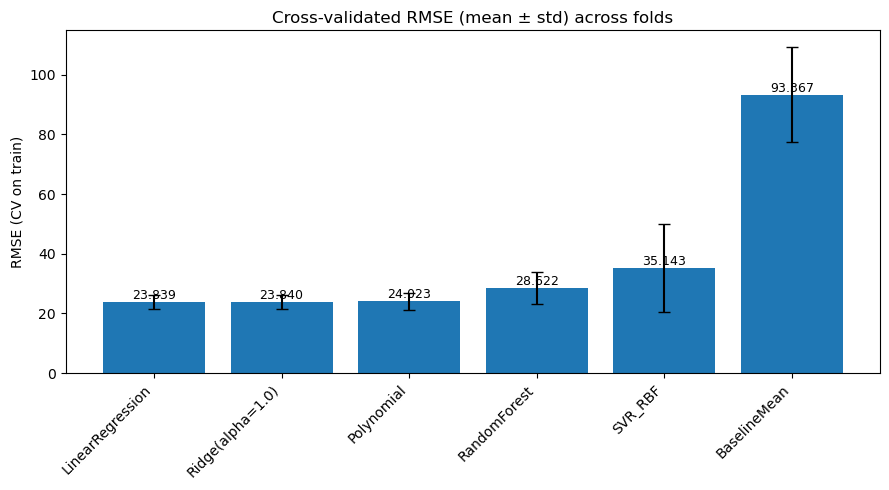

In [17]:
import matplotlib.pyplot as plt

models = cv_summary.index
means  = cv_summary["rmse_mean"].values
stds   = cv_summary["rmse_std"].values

x = np.arange(len(models))

fig, ax = plt.subplots(figsize=(9, 5))

ax.bar(x, means, yerr=stds, capsize=4)
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha="right")
ax.set_ylabel("RMSE (CV on train)")
ax.set_title("Cross-validated RMSE (mean ± std) across folds")


for i, m in enumerate(means):
    ax.text(
        x[i],
        m,
        f"{m:.3f}",
        ha="center",
        va="bottom",
        fontsize=9,
    )

plt.tight_layout()
plt.show()


# Tune Hyperparameter

In [ ]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# ---------------------------------
# Time-series cross-validation on TRAIN only
# ---------------------------------
ts_cv = TimeSeriesSplit(n_splits=5)

tuned_rows = []

# ---------------------------------
# 1) Baseline (no tuning)
# ---------------------------------
baseline = DummyRegressor(strategy="mean")
baseline_pipe = Pipeline([
    ("pre", preprocessor),     # still run preprocessor for consistency
    ("model", baseline)
])

neg_mse_cv = cross_val_score(
    baseline_pipe,
    X_train, y_train,
    scoring="neg_mean_squared_error",
    cv=ts_cv,
    n_jobs=-1
)
baseline_rmse_cv = np.sqrt(-neg_mse_cv)

baseline_pipe.fit(X_train, y_train)
y_val_pred  = baseline_pipe.predict(X_val)
y_test_pred = baseline_pipe.predict(X_test)

baseline_val_rmse  = np.sqrt(mean_squared_error(y_val,  y_val_pred))
baseline_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

tuned_rows.append({
    "model": "BaselineMean",
    "best_params": {},
    "cv_rmse_mean": baseline_rmse_cv.mean(),
    "cv_rmse_std":  baseline_rmse_cv.std(),
    "val_rmse":     baseline_val_rmse,
    "test_rmse":    baseline_test_rmse
})

print(f"[Baseline] CV RMSE: {baseline_rmse_cv.mean():.5f} ± {baseline_rmse_cv.std():.5f}")
print(f"[Baseline] Val RMSE: {baseline_val_rmse:.5f}, Test RMSE: {baseline_test_rmse:.5f}")


# ---------------------------------
# Helper: run grid search + collect metrics
# ---------------------------------
def tune_model(name, base_pipe, param_grid):
    grid = GridSearchCV(
        estimator=base_pipe,
        param_grid=param_grid,
        cv=ts_cv,
        scoring="neg_mean_squared_error",
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)

    best_est    = grid.best_estimator_
    best_params = grid.best_params_

    # RMSE by fold for the best estimator
    neg_mse_scores = cross_val_score(
        best_est,
        X_train, y_train,
        scoring="neg_mean_squared_error",
        cv=ts_cv,
        n_jobs=-1
    )
    rmse_scores = np.sqrt(-neg_mse_scores)

    # Evaluate on val & test (single final split)
    y_val_pred  = best_est.predict(X_val)
    y_test_pred = best_est.predict(X_test)
    val_rmse  = np.sqrt(mean_squared_error(y_val,  y_val_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    tuned_rows.append({
        "model":        name,
        "best_params":  best_params,
        "cv_rmse_mean": rmse_scores.mean(),
        "cv_rmse_std":  rmse_scores.std(),
        "val_rmse":     val_rmse,
        "test_rmse":    test_rmse
    })

    print(f"\n[{name}] best params: {best_params}")
    print(f"[{name}] CV RMSE: {rmse_scores.mean():.5f} ± {rmse_scores.std():.5f}")
    print(f"[{name}] Val RMSE: {val_rmse:.5f}, Test RMSE: {test_rmse:.5f}")


# ---------------------------------
# 2) Linear Regression
# ---------------------------------
lin = LinearRegression()
lin_pipe = Pipeline([
    ("pre", preprocessor),
    ("model", lin)
])
lin_grid = {
    "model__fit_intercept": [True, False],
    # uncomment if your sklearn version supports it:
    # "model__positive": [False, True],
}
tune_model("LinearRegression", lin_pipe, lin_grid)


# ---------------------------------
# 3) Ridge Regression
# ---------------------------------
ridge = Ridge()
ridge_pipe = Pipeline([
    ("pre", preprocessor),
    ("model", ridge)
])
ridge_grid = {
    # log-spaced from very small to strong regularization
    "model__alpha": np.logspace(-3, 3, 7)   # [0.001, 0.01, ..., 1000]
}
tune_model("Ridge", ridge_pipe, ridge_grid)


# ---------------------------------
# 4) Polynomial Regression + Linear
# ---------------------------------
poly_lin = Pipeline([
    ("poly", PolynomialFeatures(include_bias=False)),
    ("lin", LinearRegression())
])
poly_pipe = Pipeline([
    ("pre", preprocessor),
    ("model", poly_lin)
])
poly_grid = {
    "model__poly__degree": [1, 2, 3]
}
tune_model("Polynomial", poly_pipe, poly_grid)


# ---------------------------------
# 5) Random Forest Regressor
# ---------------------------------
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_pipe = Pipeline([
    ("pre", preprocessor),
    ("model", rf)
])
rf_grid = {
    "model__n_estimators":     [200, 400],
    "model__max_depth":        [10, 30, None],
    "model__max_features":     ["sqrt", 0.5],
    "model__min_samples_leaf": [1, 3, 5],
    "model__min_samples_split":[2, 5]
}
tune_model("RandomForest", rf_pipe, rf_grid)


# ---------------------------------
# 6) SVR with RBF kernel
# ---------------------------------
svr = SVR(kernel="rbf")
svr_pipe = Pipeline([
    ("pre", preprocessor),
    ("model", svr)
])
svr_grid = {
    "model__C":       [1, 10, 100, 300],
    "model__gamma":   ["scale", 0.3, 0.1, 0.03, 0.01],
    "model__epsilon": [0.1, 0.5, 1.0],
}
tune_model("SVR_RBF", svr_pipe, svr_grid)


# ---------------------------------
# 7) Summary table
# ---------------------------------
tuned_df = pd.DataFrame(tuned_rows).set_index("model")
print("\n=== Tuned models summary ===")
print(tuned_df[["cv_rmse_mean", "cv_rmse_std", "val_rmse", "test_rmse"]].round(3))


[Baseline] CV RMSE: 93.36676 ± 16.04466
[Baseline] Val RMSE: 97.81103, Test RMSE: 89.08942
Fitting 5 folds for each of 2 candidates, totalling 10 fits

[LinearRegression] best params: {'model__fit_intercept': True}
[LinearRegression] CV RMSE: 23.83870 ± 2.33064
[LinearRegression] Val RMSE: 24.47228, Test RMSE: 18.52926
Fitting 5 folds for each of 7 candidates, totalling 35 fits

[Ridge] best params: {'model__alpha': np.float64(0.001)}
[Ridge] CV RMSE: 23.83870 ± 2.33064
[Ridge] Val RMSE: 24.47228, Test RMSE: 18.52926
Fitting 5 folds for each of 3 candidates, totalling 15 fits

[Poly + Linear] best params: {'model__poly__degree': 1}
[Poly + Linear] CV RMSE: 23.83870 ± 2.33064
[Poly + Linear] Val RMSE: 24.47228, Test RMSE: 18.52926
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/opt/miniconda3/envs/data1030/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



[RandomForest] best params: {'model__max_depth': None, 'model__max_features': 0.5, 'model__min_samples_leaf': 3, 'model__min_samples_split': 2, 'model__n_estimators': 400}
[RandomForest] CV RMSE: 25.84095 ± 4.28843
[RandomForest] Val RMSE: 24.81766, Test RMSE: 18.14623
Fitting 5 folds for each of 60 candidates, totalling 300 fits

[SVR_RBF] best params: {'model__C': 300, 'model__epsilon': 1.0, 'model__gamma': 0.01}
[SVR_RBF] CV RMSE: 24.24018 ± 3.00771
[SVR_RBF] Val RMSE: 23.83844, Test RMSE: 18.10218

=== Tuned models summary ===
                  cv_rmse_mean  cv_rmse_std  val_rmse  test_rmse
model                                                           
BaselineMean            93.367       16.045    97.811     89.089
LinearRegression        23.839        2.331    24.472     18.529
Ridge                   23.839        2.331    24.472     18.529
Poly + Linear           23.839        2.331    24.472     18.529
RandomForest            25.841        4.288    24.818     18.146
SVR_RBF

# Results


Baseline & test scores for each algorithm

In [32]:
import pandas as pd
import numpy as np

# Build DataFrame from tuned_rows: one row per model
df_cv = pd.DataFrame(tuned_rows).set_index("model")

# Sort by mean CV RMSE (lower is better)
df_cv = df_cv.sort_values("cv_rmse_mean")
print("Models & CV RMSE summary (sorted, lower is better):")
print(df_cv[["cv_rmse_mean", "cv_rmse_std", "val_rmse", "test_rmse"]].round(3))

# ---------- (a) Baseline summary ----------
baseline_mean = df_cv.loc["BaselineMean", "cv_rmse_mean"]
baseline_std  = df_cv.loc["BaselineMean", "cv_rmse_std"]

print(f"\nBaseline (DummyRegressor) CV RMSE: "
      f"{baseline_mean:.3f} ± {baseline_std:.3f}")

# ---------- (b) Best ML model EXCLUDING baseline ----------
ml_only = df_cv.drop(index="BaselineMean")        # drop baseline row
best_model_name = ml_only["cv_rmse_mean"].idxmin()   # model with smallest mean CV RMSE
best_rmse_mean  = ml_only.loc[best_model_name, "cv_rmse_mean"]
best_rmse_std   = ml_only.loc[best_model_name, "cv_rmse_std"]

print(f"\nBest ML model (excluding baseline): {best_model_name}")
print(f"  CV RMSE ≈ {best_rmse_mean:.3f} ± {best_rmse_std:.3f}")

# ---------- (c) Improvement over baseline ----------
improvement = baseline_mean - best_rmse_mean      # positive = better than baseline
frac_improvement = improvement / baseline_mean    # fractional improvement

if baseline_std > 0:
    std_improvement = improvement / baseline_std
else:
    std_improvement = np.nan

print(f"\nImprovement over baseline: {improvement:.3f} RMSE")
print(f"  Fraction of baseline RMSE: {frac_improvement:.3f} "
      f"(~{frac_improvement*100:.1f}% better)")
print(f"  In units of baseline std: {std_improvement:.3f} standard deviations better")

# ---------- (d) (Optional) overall best including baseline ----------
overall_best_name = df_cv["cv_rmse_mean"].idxmin()
overall_best_mean = df_cv.loc[overall_best_name, "cv_rmse_mean"]
print(f"\nOverall best (including baseline): {overall_best_name} "
      f"with CV RMSE ≈ {overall_best_mean:.3f}")


Models & CV RMSE summary (sorted, lower is better):
                  cv_rmse_mean  cv_rmse_std  val_rmse  test_rmse
model                                                           
Poly + Linear           23.839        2.331    24.472     18.529
LinearRegression        23.839        2.331    24.472     18.529
Ridge                   23.839        2.331    24.472     18.529
SVR_RBF                 24.240        3.008    23.838     18.102
RandomForest            25.841        4.288    24.818     18.146
BaselineMean            93.367       16.045    97.811     89.089

Baseline (DummyRegressor) CV RMSE: 93.367 ± 16.045

Best ML model (excluding baseline): Poly + Linear
  CV RMSE ≈ 23.839 ± 2.331

Improvement over baseline: 69.528 RMSE
  Fraction of baseline RMSE: 0.745 (~74.5% better)
  In units of baseline std: 4.333 standard deviations better

Overall best (including baseline): Poly + Linear with CV RMSE ≈ 23.839


In [24]:
import pandas as pd

# Use the tuned_df DataFrame produced earlier (tuned_summary was not defined)
# tuned_df: index = model name, cols = best_params, cv_rmse_mean, cv_rmse_std, val_rmse, test_rmse

results_table = (
    tuned_df
    .reset_index()
    .rename(columns={
        "model": "Model",
        "cv_rmse_mean": "CV RMSE (mean)",
        "cv_rmse_std":  "CV RMSE (std)",
        "val_rmse":     "Val RMSE",
        "test_rmse":    "Test RMSE"
    })
)

# Sort by Test RMSE (best at top) and round for nicer display
results_table = (
    results_table
    .sort_values("Test RMSE")
    .reset_index(drop=True)
    .round(5)
)

print("Models & Test Performance (RMSE)")
display(results_table)


Models & Test Performance (RMSE)


,Model,best_params,CV RMSE (mean),CV RMSE (std),Val RMSE,Test RMSE
0,SVR_RBF,"{'model__C': 300, 'model__epsilon': 1.0, 'mode...",24.24018,3.00771,23.83844,18.10218
1,RandomForest,"{'model__max_depth': None, 'model__max_feature...",25.84095,4.28843,24.81766,18.14623
2,LinearRegression,{'model__fit_intercept': True},23.83870,2.33064,24.47228,18.52926
3,Poly + Linear,{'model__poly__degree': 1},23.83870,2.33064,24.47228,18.52926
4,Ridge,{'model__alpha': 0.001},23.83870,2.33064,24.47228,18.52926
5,BaselineMean,{},93.36676,16.04466,97.81103,89.08942


2️⃣ Plot means & standard deviations 

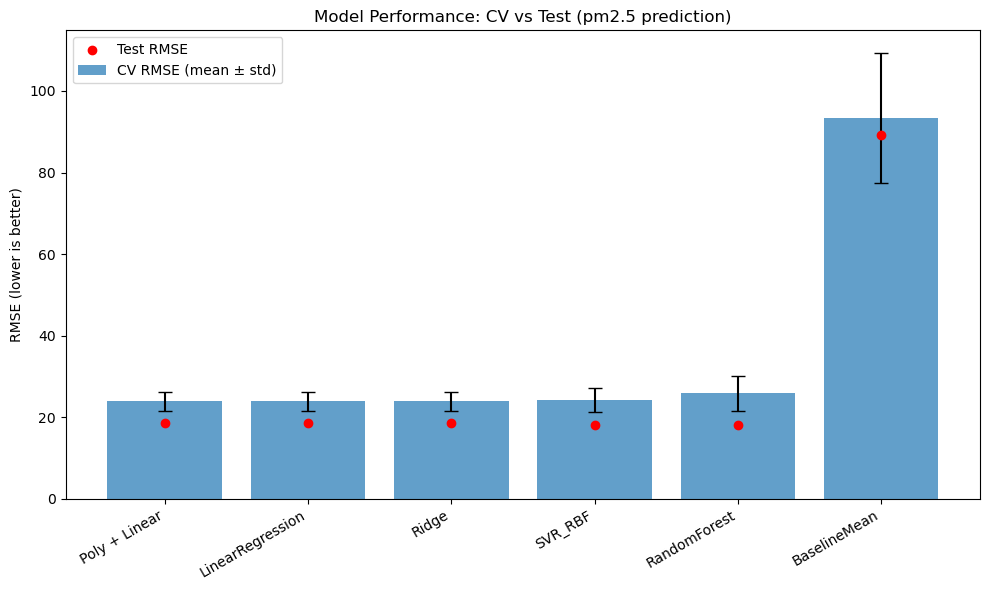

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# tuned_df should be the summary you printed:
# columns: ["cv_rmse_mean", "cv_rmse_std", "val_rmse", "test_rmse"]
# index:   model names ("BaselineMean", "LinearRegression", ...)

# 1) Sort models by CV performance (lower RMSE is better)
plot_df = tuned_df.sort_values("cv_rmse_mean", ascending=True).copy()

models     = plot_df.index.to_list()
cv_means   = plot_df["cv_rmse_mean"].values
cv_stds    = plot_df["cv_rmse_std"].values
test_rmse  = plot_df["test_rmse"].values

x = np.arange(len(models))

# 2) Make the figure
plt.figure(figsize=(10, 6))

# Blue bars = mean CV RMSE, with error bars = std
bar = plt.bar(x, cv_means, yerr=cv_stds, capsize=5, alpha=0.7, label="CV RMSE (mean ± std)")

# Red dots = test RMSE
plt.scatter(x, test_rmse, color="red", marker="o", label="Test RMSE", zorder=3)

# 3) Labels / formatting
plt.xticks(x, models, rotation=30, ha="right")
plt.ylabel("RMSE (lower is better)")
plt.title("Model Performance: CV vs Test (pm2.5 prediction)")
plt.legend()

plt.tight_layout()
plt.show()


#  Interpretability

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

# LinearRegression is your best CV model
lin = LinearRegression(fit_intercept=True)

lin_pipe = Pipeline([
    ("pre", preprocessor),   # SimpleImputer + StandardScaler
    ("model", lin),
])

lin_pipe.fit(X_train, y_train)


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['DEWP', 'TEMP', 'PRES',
                                                   'Iws', 'Is', 'Ir',
                                                   'hour_sin', 'hour_cos',
                                                   'pm2_1', 'pm2_24',
                                                   'pm2_24_mean'])])),
                ('model', LinearRegression())])

1. Global importance #1 – absolute standardized coefficients

Global importance #1 – |standardized coefficients|:
pm2_1          86.882190
TEMP            8.973312
DEWP            7.590235
hour_sin        3.799031
PRES            1.551965
pm2_24_mean     1.490709
Ir              1.483677
Iws             0.741444
pm2_24          0.740097
hour_cos        0.671702
Is              0.293759
dtype: float64


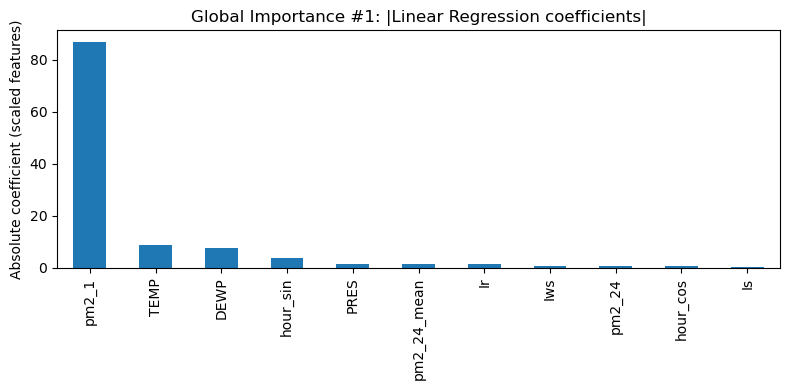

In [27]:
lin_model = lin_pipe.named_steps["model"]

coef_abs = np.abs(lin_model.coef_)
fi_coef = pd.Series(coef_abs, index=candidate_features).sort_values(ascending=False)

print("Global importance #1 – |standardized coefficients|:")
print(fi_coef)

plt.figure(figsize=(8,4))
fi_coef.head(11).plot(kind="bar")
plt.title("Global Importance #1: |Linear Regression coefficients|")
plt.ylabel("Absolute coefficient (scaled features)")
plt.tight_layout()
plt.show()


2. Global importance #2 – permutation importance (validation set)

Global importance #2 – permutation importance on validation:
pm2_1          17201.139430
TEMP             157.881082
DEWP              79.542934
hour_sin          27.405479
pm2_24_mean        2.911351
Ir                 2.837837
pm2_24             2.390093
PRES               0.697491
Iws                0.638967
Is                 0.254477
hour_cos           0.171763
dtype: float64


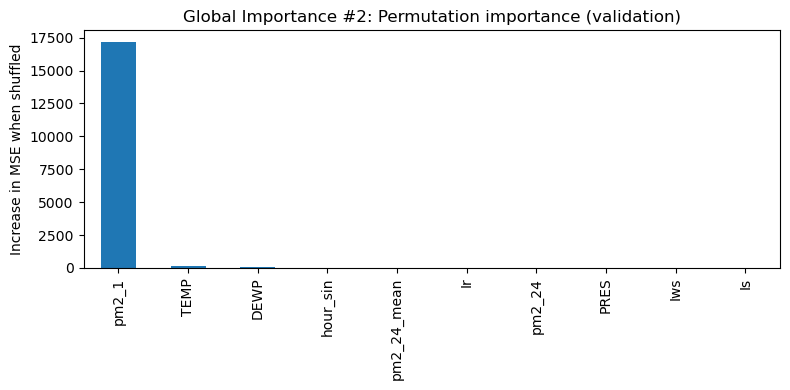

In [28]:
from sklearn.inspection import permutation_importance


perm_res = permutation_importance(
    lin_pipe,
    X_val, y_val,
    n_repeats=20,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    random_state=0,
)

# Already: increase in MSE when shuffled (positive if important)
perm_imp = perm_res.importances_mean

fi_perm = pd.Series(perm_imp, index=candidate_features).sort_values(ascending=False)

print("Global importance #2 – permutation importance on validation:")
print(fi_perm)

plt.figure(figsize=(8,4))
fi_perm.head(10).plot(kind="bar")
plt.title("Global Importance #2: Permutation importance (validation)")
plt.ylabel("Increase in MSE when shuffled")
plt.tight_layout()
plt.show()


3. Global importance #3 – SHAP (mean |SHAP| on validation)


Global importance #3 – SHAP (mean |SHAP| on validation):
pm2_1          70.624401
TEMP            7.364292
DEWP            6.051100
hour_sin        3.401112
PRES            1.294667
pm2_24_mean     1.213469
hour_cos        0.609318
pm2_24          0.580881
Iws             0.327005
Ir              0.307192
Is              0.054399
dtype: float64


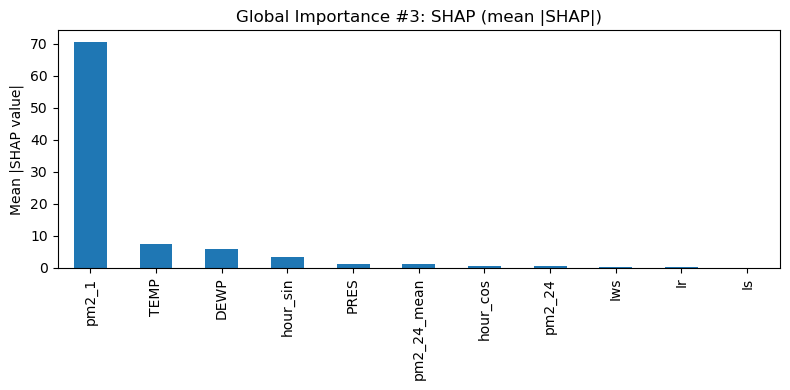

In [29]:
import shap

# Preprocess train & val into dense arrays
X_train_prep = lin_pipe.named_steps["pre"].transform(X_train)
X_val_prep   = lin_pipe.named_steps["pre"].transform(X_val)

explainer_lin = shap.LinearExplainer(
    lin_model,
    X_train_prep
)

shap_vals_val = explainer_lin.shap_values(X_val_prep)   # shape: (n_val, n_features)

shap_mean = np.abs(shap_vals_val).mean(axis=0)
fi_shap = pd.Series(shap_mean, index=candidate_features).sort_values(ascending=False)

print("\nGlobal importance #3 – SHAP (mean |SHAP| on validation):")
print(fi_shap)

plt.figure(figsize=(8,4))
fi_shap.head(11).plot(kind="bar")
plt.title("Global Importance #3: SHAP (mean |SHAP|)")
plt.ylabel("Mean |SHAP value|")
plt.tight_layout()
plt.show()


4. Local interpretability – SHAP for one test example

Test example index: 3537
  True pm2.5: 522.0
  Predicted pm2.5: 486.5527230437255


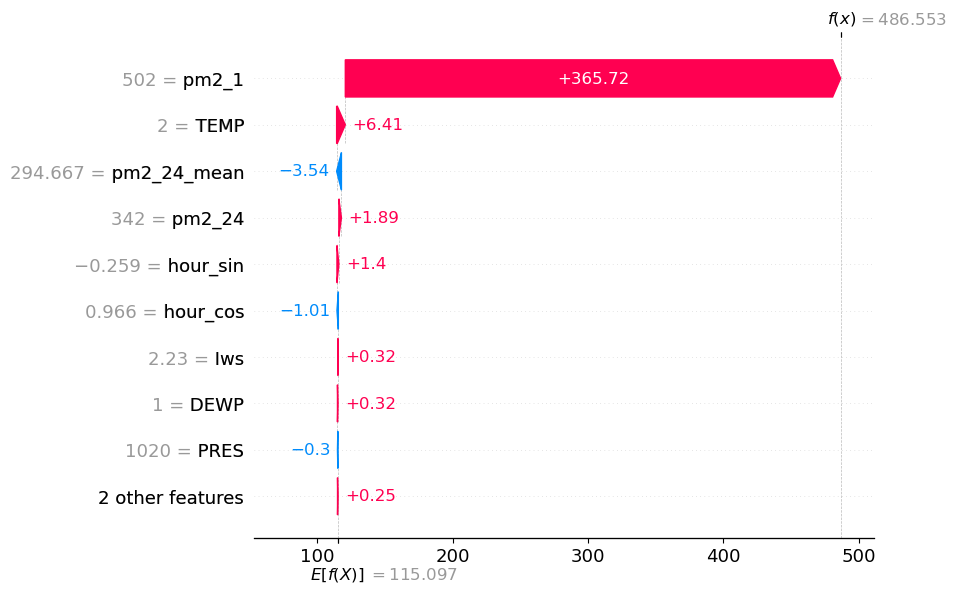

In [30]:
# 1) Pick a test example (here: index of max true pm2.5 in test)
idx = int(np.argmax(y_test.values))

X_row  = X_test.iloc[[idx]]
y_true = y_test.iloc[idx]
y_pred = lin_pipe.predict(X_row)[0]

print(f"Test example index: {idx}")
print("  True pm2.5:", y_true)
print("  Predicted pm2.5:", y_pred)

# 2) Preprocess and get SHAP values for this single row
X_row_prep = lin_pipe.named_steps["pre"].transform(X_row)
shap_row   = explainer_lin.shap_values(X_row_prep)[0]   # shape: (n_features,)
base_val   = explainer_lin.expected_value               # model’s baseline prediction

# 3) Build a SHAP Explanation object
exp = shap.Explanation(
    values        = shap_row,
    base_values   = base_val,
    data          = X_row.values[0],
    feature_names = candidate_features,
)

# 4) Waterfall plot (this is the style from the slide screenshot)
shap.plots.waterfall(exp, max_display=10)


# Outlook

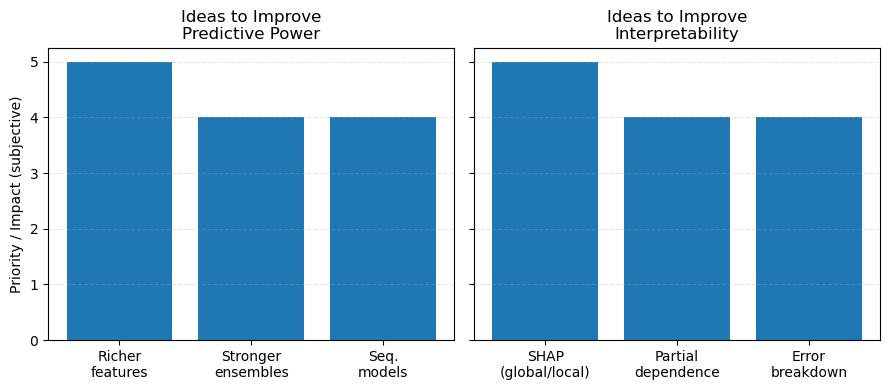

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Items (short labels for the x-axis)
pred_items = [
    "Richer\nfeatures",
    "Stronger\nensembles",
    "Seq.\nmodels"
]
interp_items = [
    "SHAP\n(global/local)",
    "Partial\ndependence",
    "Error\nbreakdown"
]

# Subjective “priority/impact” scores (1–5) just for visualization
pred_scores = [5, 4, 4]
interp_scores = [5, 4, 4]

fig, axes = plt.subplots(1, 2, figsize=(9, 4), sharey=True)

# Left: predictive power ideas
axes[0].bar(pred_items, pred_scores)
axes[0].set_title("Ideas to Improve\nPredictive Power")
axes[0].set_ylabel("Priority / Impact (subjective)")
axes[0].grid(axis="y", linestyle="--", alpha=0.3)

# Right: interpretability ideas
axes[1].bar(interp_items, interp_scores)
axes[1].set_title("Ideas to Improve\nInterpretability")
axes[1].grid(axis="y", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()
